In [1]:
# General support
import math
import tensorflow as tf
import numpy as np

# For plots
import matplotlib.pyplot as plt

# Dimensionality reduction
import umap
from sklearn.manifold import TSNE

# General lucid code
from lucid.misc.io import save, show, load
import lucid.modelzoo.vision_models as models

# For rendering feature visualizations
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

/home/vkeilo/miniconda3/envs/Atlas/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load paginated data:

In [2]:
# from progressbar import progressbar
from tqdm import tqdm
from os.path import join


# URL Helpers

def path_segment(key_value_pairs):
    segments = [f"{key}={value}" for key, value in key_value_pairs]
    return "/".join(segments)


def parameterized_url(root_url, path, kv_pairs):
    if path is not None:
        url = join(root_url, path)
    else:
        url = root_url
    path = path_segment(kv_pairs)
    return join(url, path)


# Paginated Data Loading

def load_data(data_type, layer_name, length=1_048_576, paginated=True):
    parameters = ('dataset', 'ImageNet-train'), ('model', 'InceptionV1'), ('layer', layer_name)
    root_url = parameterized_url("gs://modelzoo", "aligned-activations-and-attributions", parameters)

    activations_per_page = int(2**14)  # 16_384
    number_of_pages = int(2**6)  # 64
    number_of_pages_to_load = math.ceil(length / activations_per_page)

    results = []
    for page_index in tqdm(range(number_of_pages_to_load)):
        url = f"{root_url}/{data_type}-{page_index:05}-of-{number_of_pages:05}.npy"
        results.append(load(url))

    return np.concatenate(results)[:length, ...]


# Convenience functions

def load_activations(layer, length=1_048_576):
    return load_data("activations", layer, length)


def load_attributions(layer, length=1_048_576):
    return load_data("attributions", layer, length)

These functions are explained in more detail in the simple-activation-atlas example.

In [3]:
def whiten(full_activations):
    correl = np.matmul(full_activations.T, full_activations) / len(full_activations)
    correl = correl.astype("float32")
    S = np.linalg.inv(correl)
    S = S.astype("float32")
    return S

def normalize_layout(layout, min_percentile=1, max_percentile=99, relative_margin=0.1):
    """Removes outliers and scales layout to between [0,1]."""

    # compute percentiles
    mins = np.percentile(layout, min_percentile, axis=(0))
    maxs = np.percentile(layout, max_percentile, axis=(0))

    # add margins
    mins -= relative_margin * (maxs - mins)
    maxs += relative_margin * (maxs - mins)

    # `clip` broadcasts, `[None]`s added only for readability
    clipped = np.clip(layout, mins, maxs)

    # embed within [0,1] along both axes
    clipped -= clipped.min(axis=0)
    clipped /= clipped.max(axis=0)

    return clipped


def grid(xpts=None, ypts=None, grid_size=(8,8), x_extent=(0., 1.), y_extent=(0., 1.)):
    xpx_length = grid_size[0]
    ypx_length = grid_size[1]

    xpt_extent = x_extent
    ypt_extent = y_extent

    xpt_length = xpt_extent[1] - xpt_extent[0]
    ypt_length = ypt_extent[1] - ypt_extent[0]

    xpxs = ((xpts - xpt_extent[0]) / xpt_length) * xpx_length
    ypxs = ((ypts - ypt_extent[0]) / ypt_length) * ypx_length

    ix_s = range(grid_size[0])
    iy_s = range(grid_size[1])
    xs = []
    for xi in ix_s:
        ys = []
        for yi in iy_s:
            xpx_extent = (xi, (xi + 1))
            ypx_extent = (yi, (yi + 1))

            in_bounds_x = np.logical_and(xpx_extent[0] <= xpxs, xpxs <= xpx_extent[1])
            in_bounds_y = np.logical_and(ypx_extent[0] <= ypxs, ypxs <= ypx_extent[1])
            in_bounds = np.logical_and(in_bounds_x, in_bounds_y)

            in_bounds_indices = np.where(in_bounds)[0]
            ys.append(in_bounds_indices)
        xs.append(ys)
    return np.asarray(xs)


@objectives.wrap_objective
def direction_neuron_S(layer_name, vec, batch=None, x=None, y=None, S=None):
  def inner(T):
    layer = T(layer_name)
    shape = tf.shape(layer)
    x_ = shape[1] // 2 if x is None else x
    y_ = shape[2] // 2 if y is None else y
    if batch is None:
      raise RuntimeError("requires batch")

    acts = layer[batch, x_, y_]
    vec_ = vec
    if S is not None: vec_ = tf.matmul(vec_[None], S)[0]
    # mag = tf.sqrt(tf.reduce_sum(acts**2))
    dot = tf.reduce_mean(acts * vec_)
    # cossim = dot/(1e-4 + mag)
    return dot
  return inner


@objectives.wrap_objective
def direction_neuron_cossim_S(layer_name, vec, batch=None, x=None, y=None, cossim_pow=1, S=None):
  def inner(T):
    layer = T(layer_name)
    shape = tf.shape(layer)
    x_ = shape[1] // 2 if x is None else x
    y_ = shape[2] // 2 if y is None else y
    if batch is None:
      raise RuntimeError("requires batch")

    acts = layer[batch, x_, y_]
    vec_ = vec
    if S is not None: vec_ = tf.matmul(vec_[None], S)[0]
    mag = tf.sqrt(tf.reduce_sum(acts**2))
    dot = tf.reduce_mean(acts * vec_)
    cossim = dot/(1e-4 + mag)
    cossim = tf.maximum(0.1, cossim)
    return dot * cossim ** cossim_pow
  return inner


def render_icons(directions, model, layer, size=80, n_steps=128, verbose=False, S=None, num_attempts=2, cossim=True, alpha=True):
  image_attempts = []
  loss_attempts = []
  
  # Render multiple attempts, and pull the one with the lowest loss score.
  for attempt in range(num_attempts):
    
    # Render an image for each activation vector
    param_f = lambda: param.image(size, batch=directions.shape[0], fft=True, decorrelate=True, alpha=alpha)
    if(S is not None):
        if(cossim is True):
            obj_list = ([
              direction_neuron_cossim_S(layer, v, batch=n, S=S, cossim_pow=4) for n,v in enumerate(directions)
            ]) 
        else: 
            obj_list = ([
              direction_neuron_S(layer, v, batch=n, S=S) for n,v in enumerate(directions)
            ])    
    else: 
        obj_list = ([
          objectives.direction_neuron(layer, v, batch=n) for n,v in enumerate(directions)
        ])

    obj = objectives.Objective.sum(obj_list)

    transforms = []
    if alpha:
      transforms.append(transform.collapse_alpha_random())
    transforms.append(transform.pad(2, mode='constant', constant_value=1))
    transforms.append(transform.jitter(4))
    transforms.append(transform.jitter(4))
    transforms.append(transform.jitter(8))
    transforms.append(transform.jitter(8))
    transforms.append(transform.jitter(8))
    transforms.append(transform.random_scale([0.995**n for n in range(-5,80)] + [0.998**n for n in 2*list(range(20,40))]))
    transforms.append(transform.random_rotate(list(range(-20,20))+list(range(-10,10))+list(range(-5,5))+5*[0]))
    transforms.append(transform.jitter(2))

    # This is the tensorflow optimization process
  
    print("attempt: ", attempt)
    with tf.Graph().as_default(), tf.Session() as sess:
      learning_rate = 0.05
      losses = []
      trainer = tf.train.AdamOptimizer(learning_rate)
      T = render.make_vis_T(model, obj, param_f, trainer, transforms)
      loss_t, vis_op, t_image = T("loss"), T("vis_op"), T("input")
      losses_ = [obj_part(T) for obj_part in obj_list]
      tf.global_variables_initializer().run()
      for i in range(n_steps):
        loss, _ = sess.run([losses_, vis_op])
        losses.append(loss)
        if (i % 100 == 0):
            print(i)

      img = t_image.eval()
      img_rgb = img[:,:,:,:3]
      if alpha:
        print("alpha true")
        k = 0.8
        bg_color = 0.0
        img_a = img[:,:,:,3:]
        img_merged = img_rgb*((1-k)+k*img_a) + bg_color * k*(1-img_a)
        image_attempts.append(img_merged)
      else:
        print("alpha false")
        image_attempts.append(img_rgb)

      loss_attempts.append(losses[-1])

  # Use only the icons with the lowest loss
  loss_attempts = np.asarray(loss_attempts)   
  loss_final = []
  image_final = []
  print("merging best scores from attempts...")
  for i, d in enumerate(directions):
    # note, this should be max, it is not a traditional loss
    mi = np.argmax(loss_attempts[:,i])
    image_final.append(image_attempts[mi][i])
    
  return (image_final, loss_final)


def render_layout(model, layer, S, xs, ys, activ, n_steps=512, n_attempts=2, min_density=10, grid_size=(10, 10), icon_size=80, x_extent=(0., 1.0), y_extent=(0., 1.0)):
    grid_layout = grid(xpts=xs, ypts=ys, grid_size=grid_size, x_extent=x_extent, y_extent=y_extent)
    icons = []

    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            indices = grid_layout[x, y]
            if len(indices) > min_density:
                average_activation = np.average(activ[indices], axis=0)
                icons.append((average_activation, x, y))

    icons = np.asarray(icons)
    icon_batch, losses = render_icons(icons[:,0], model, alpha=False, layer=layer, S=S, n_steps=n_steps, size=icon_size, num_attempts=n_attempts)

    canvas = np.ones((icon_size * grid_size[0], icon_size * grid_size[1], 3))
    for i, icon in enumerate(icon_batch):
        y = int(icons[i, 1])
        x = int(icons[i, 2])
        canvas[(grid_size[0] - x - 1) * icon_size:(grid_size[0] - x) * icon_size, (y) * icon_size:(y + 1) * icon_size] = icon

    return canvas

#### Load model and activations

In [7]:
model = models.InceptionV1()
model.load_graphdef()

URLError: <urlopen error [Errno 104] Connection reset by peer>

set proxy if you need

In [6]:
# 导入模块
import os
# 设置代理。这里 1080 既可以是 http 代理的端口，也可以是 socks5 代理的端口
proxy = 'http://127.0.0.1:16888'
os.environ['http_proxy'] = proxy
os.environ['HTTP_PROXY'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTPS_PROXY'] = proxy

# # 或者删除这些环境变量
# del os.environ['http_proxy']
# del os.environ['HTTP_PROXY']
# del os.environ['https_proxy']
# del os.environ['HTTPS_PROXY']

In [27]:
layer = "mixed5b"
num_activations = 400000

In [8]:
# 这里需要科学上网，可以直接加载本地数据
activations = load_activations(layer=layer, length=num_activations)
attributions = load_attributions(layer=layer, length=num_activations)

100%|██████████| 25/25 [09:45<00:00, 23.44s/it]


In [9]:
from joblib import dump, load

# 保存单个变量到本地文件
def save_variable(filename, variable):
    dump(variable, filename)

# 加载本地文件中的单个变量
def load_variable(filename):
    return load(filename)

# # 保存 activations 到本地文件
# save_variable('datas/activations.joblib', activations)

# # 保存 attributions 到本地文件
# save_variable('datas/attributions.joblib', attributions)

# 加载本地文件中的 activations
activations = load_variable('datas/activations.joblib')

# 加载本地文件中的 attributions
attributions = load_variable('datas/attributions.joblib')



In [13]:
S = whiten(activations)

#### A Single Class

In [14]:
def get_winning_indices(attributions, class_id):
  matching_indices = []
  for i, attr in enumerate(attributions):
    class_indices = np.argsort(-attr)
    if class_id in class_indices[0:1]:
      matching_indices.append(i)
  return np.array(matching_indices)


def get_top_indices(attributions, class_id, n=2000):
  top_indices = np.argsort(-attributions[:,class_id])[0:n]
  positive = attributions[top_indices, class_id] > 0
  return top_indices[positive]

In [15]:
# 6 grey whale
# 442 great white shark
# 671 frying pan
# 672 wok
# 235 fireboat
# 287 streetcar
# 982 scuba diver
# 507 snorkel
# 547 abacus
# 930 comic book
# 600 spider web

class_filter = 982

In [16]:
winning_indices = get_winning_indices(attributions, class_filter)
top_indices = get_top_indices(attributions, class_filter, 3000)
combined_indices = np.concatenate((top_indices, winning_indices), axis=0)

In [17]:
filtered_activations = activations[combined_indices]
filtered_attributions = attributions[combined_indices]

In [18]:
points = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.01, metric="cosine", verbose=True).fit_transform(filtered_activations)

# You could use TSNE as well if you like
# points = TSNE(n_components=2, verbose=False, metric="cosine", learning_rate=10, perplexity=50).fit_transform(filtered_activations)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_neighbors=20, verbose=True)
Mon Mar  4 21:09:50 2024 Construct fuzzy simplicial set
Mon Mar  4 21:09:57 2024 Finding Nearest Neighbors
Mon Mar  4 21:09:58 2024 Finished Nearest Neighbor Search
Mon Mar  4 21:09:59 2024 Construct embedding


Epochs completed:   3%| ▎          17/500 [00:00]

	completed  0  /  500 epochs


Epochs completed:  16%| █▌         78/500 [00:01]

	completed  50  /  500 epochs


Epochs completed:  28%| ██▊        140/500 [00:01]

	completed  100  /  500 epochs


Epochs completed:  36%| ███▌       181/500 [00:01]

	completed  150  /  500 epochs


Epochs completed:  44%| ████▍      219/500 [00:02]

	completed  200  /  500 epochs


Epochs completed:  51%| █████▏     257/500 [00:02]

	completed  250  /  500 epochs


Epochs completed:  68%| ██████▊    339/500 [00:03]

	completed  300  /  500 epochs


Epochs completed:  76%| ███████▌   380/500 [00:03]

	completed  350  /  500 epochs


Epochs completed:  80%| ███████▉   399/500 [00:03]

	completed  400  /  500 epochs


Epochs completed:  90%| █████████  450/500 [00:04]

	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:04]

Mon Mar  4 21:10:03 2024 Finished embedding


In [19]:
layout = normalize_layout(points, min_percentile=1, max_percentile=99)

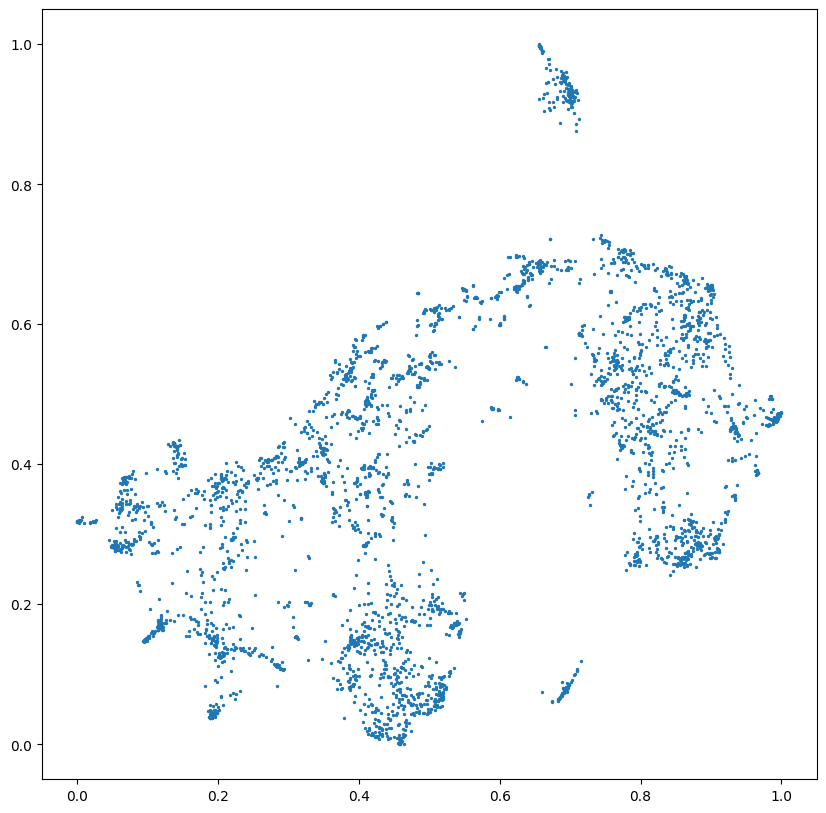

In [20]:
plt.figure(figsize=(10, 10))
plt.scatter(x=layout[:,0],y=layout[:,1], s=2)
plt.show()

In [28]:
xs = layout[:, 0]
ys = layout[:, 1]
canvas = render_layout(model, layer, S, xs, ys, filtered_activations, grid_size=(8, 8), n_steps=512, n_attempts=2, min_density=4, x_extent=(0, 1.), y_extent=(0, 1.))
show(canvas)

/home/vkeilo/miniconda3/envs/Atlas/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


TypeError: 'mixed5b' is not a callable object

In [26]:
print(layer)


Layer (belonging to InceptionV1) <softmax2: 1008> ([{'dense'}])


In [23]:
for layer in model.layers:
    print(layer.name)

conv2d0
conv2d1
conv2d2
mixed3a
mixed3b
mixed4a
mixed4b
mixed4c
mixed4d
mixed4e
mixed5a
mixed5b
head0_bottleneck
nn0
softmax0
head1_bottleneck
nn1
softmax1
softmax2
